# Proyecto N.4
Integrantes:
- Luis Pablo López Iracheta
- Diego Mares Rodrígez
- Francisco Marín Castillo

Fecha 07/ 11/ 25

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [15]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Ingnoramos warnings de numpy

In [16]:
# Datos de entrada

U = 500 # Coeficiente global de transferencia de calor en W/(m2 * C)
T_h_in = 80 + 273.15 # Temperatura de entrada del fluido caliente en K
T_c_in = 20 + 273.15 # Temperatura de entrada del fluido frío en K

# Capacidad calorífica del agua en J/(kg * C)
C_h = 4180 
C_c = 4180 


In [17]:
# Restricciones
D_i_min = 0.01  # Diámetro interno mínimo en m
D_i_max = 0.05   # Diámetro interno máximo en m
D_o_min = 0.015  # Diámetro externo mínimo en m
D_o_max = 0.06   # Diámetro externo máximo en m

L_min = 1.0     # Longitud mínima en m
L_max = 10.0     # Longitud máxima en m

m_min = 0.05   # Fluido caliente y frío en kg/s
m_max = 0.5  # Fluido caliente y frío en kg/s 

T_h_out = 80 + 273.15  # Temperatura Provisional
Tem_Final = T_h_out > T_c_in 

eps = 0.001 # Margen mínimo entre D_o y D_i


In [18]:
def fun_objetivo(D_i, D_o, L, m_h, m_c):
    # D_i: Diámetro interno en m
    # D_o: Diámetro externo en m
    # L: Longitud en m
    # m_h: Flujo másico del fluido caliente en kg/s
    # m_c: Flujo másico del fluido frío en kg/s

    # Proceso para calcular C_min y C_max
    C_h_tot = m_h * C_h
    C_c_tot = m_c * C_c
    C_min = np.minimum(C_h_tot, C_c_tot) # Capacidad calorífica mínima
    C_max = np.maximum(C_h_tot, C_c_tot) # Capacidad calorífica máxima

    if C_min <= 0:
        C_min = 1e-6  # Evitar división por cero
    if C_max <= 0:
        C_max = 1e-6  # Evitar división por cero


    A = np.pi * D_o * L  # Área de transferencia de calor en m2

    NTU = U * A / C_min # Número de unidades de transferencia
    Cr = C_min / C_max  # Relación de capacidades

    with np.errstate(invalid='ignore', divide='ignore'): # Manejo de errores de numpy
        n = (1 - np.exp(-NTU * (1 - Cr))) / (1 - Cr * np.exp(-NTU * (1 - Cr)))
    if np.isnan(n) or np.isinf(n): # Manejo de casos indefinidos
        n = 0.0
    return n




In [19]:
def start_population(tam_pob):
    Poblacion = []
    for i in range(tam_pob):
        individuo = []
        for j in range(5):
            if j == 0:  # D_i
                valor = random.uniform(0.01, 0.05)
            elif j == 1:  # D_o
                valor = random.uniform(0.015, 0.06)
                # Valido que D_o sea mayor que D_i
                if valor <= individuo[0]:
                    diferencia = individuo[0] - valor
                    valor = valor + diferencia + 0.005
                    
            elif j == 2:  # L
                valor = random.uniform(1.0, 10.0)
            elif j == 3:  # m_h
                valor = random.uniform(0.1, 0.5)
            else:  # m_c
                valor = random.uniform(0.1, 0.5)
            individuo.append(valor)
        Poblacion.append(individuo)


    return Poblacion


In [20]:
def evaluar_poblacion(poblacion):
    resultados = []
    for individuo in poblacion:
        D_i, D_o, L, m_h, m_c = individuo

        eficacia = fun_objetivo(D_i, D_o, L, m_h, m_c)

        resultados.append(eficacia)
    return resultados

In [21]:
def mutacion_Evol_diff(poblacion, F, i):
    # Seleccionar 5 individuos distintos al individuo i
    n = len(poblacion)
    if n < 6:
        raise ValueError("La población debe tener al menos 6 individuos para la mutación diferencial.")
    
    r1, r2, r3, r4, r5 = random.sample([idx for idx in range(len(poblacion)) if idx != i], 5)

    vetor_mutado = []
    for j in range(len(poblacion[0])):
        valor_mutado = (poblacion[r1][j] + 
                        F * (poblacion[r2][j] - poblacion[r3][j]) + 
                        F * (poblacion[r4][j] - poblacion[r5][j]))
        vetor_mutado.append(valor_mutado)

    return vetor_mutado

In [22]:
# Cruce para el método de evolución diferencial
def cross_Ev_diff(individuo, vetor_mutado, Cr):
    n = len(individuo)
    hijo = []
    j_rand = random.randint(0, n - 1)  
    # Asegura que al menos un gen provenga del vector mutado
    for j in range(n):
        if random.random() < Cr or j == j_rand:
            hijo.append(vetor_mutado[j])
        else:
            hijo.append(individuo[j])
    return hijo

In [23]:
def seleccion(individuo, hijo):
    # Limites para los parámetros D_i, D_o, L, m_h, m_c
    if hijo[1] <= hijo[0] + eps:
        return individuo

    f1 = fun_objetivo(individuo[0], individuo[1], individuo[2], individuo[3], individuo[4])
    f2 = fun_objetivo(hijo[0], hijo[1], hijo[2], hijo[3], hijo[4])
    if f2 > f1: # Mayor es mejor
        return hijo
    else:
        return individuo


In [24]:
limites = [
    (0.01, 0.05),   # D_i
    (0.015, 0.06), # D_o
    (1.0, 10.0),    # L
    (0.05, 0.5),    # m_h
    (0.05, 0.5)    # m_c
]

def reparar_vector(vector): # 

    # asegurar rangos individuales
    for i, (low, high) in enumerate(limites):
        if vector[i] < low or vector[i] > high:
            vector[i] = random.uniform(low, high)
    
    return vector


In [25]:
# Función para visualizar el intercambiador de calor
def visualizar_intercambiador(D_i, D_o, L, eficacia):
    fig = plt.figure(figsize=(15, 5))
    
    # Visualización 3D del tubo
    ax1 = fig.add_subplot(131, projection='3d')
    
    # Crear coordenadas para el tubo interno
    z = np.linspace(0, L, 100) # Eje z
    theta = np.linspace(0, 2*np.pi, 100) # Ángulo alrededor del eje
    theta_grid, z_grid = np.meshgrid(theta, z) # Coordenadas de malla
    
    # Tubo interno
    x_int = (D_i/2) * np.cos(theta_grid) # Eje x
    y_int = (D_i/2) * np.sin(theta_grid) # Eje y
    
    # Tubo externo
    x_ext = (D_o/2) * np.cos(theta_grid) # Eje x
    y_ext = (D_o/2) * np.sin(theta_grid) # Eje y
    
    # Dibujar tubo interno
    ax1.plot_surface(x_int, y_int, z_grid, alpha=0.7, color='red', label='Tubo interno')
    # Dibujar tubo externo
    ax1.plot_surface(x_ext, y_ext, z_grid, alpha=0.5, color='blue', label='Tubo externo')
    
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Longitud (m)')
    ax1.set_title(f'Intercambiador de Calor - Eficacia: {eficacia:.3f}')
    
    # Vista en corte transversal
    ax2 = fig.add_subplot(132)
    circle_int = plt.Circle((0, 0), D_i/2, fill=False, color='red', linewidth=2, label=f'Tubo interno (D_i={D_i:.4f}m)')
    circle_ext = plt.Circle((0, 0), D_o/2, fill=False, color='blue', linewidth=2, label=f'Tubo externo (D_o={D_o:.4f}m)')
    
    ax2.add_patch(circle_int)
    ax2.add_patch(circle_ext)
    ax2.set_xlim(-D_o/2 - 0.03, D_o/2 + 0.03)
    ax2.set_ylim(-D_o/2 - 0.03, D_o/2 + 0.03)
    ax2.set_aspect('equal')
    ax2.set_xlabel('X (m)')
    ax2.set_ylabel('Y (m)')
    ax2.set_title('Corte Transversal')
    ax2.legend()
    ax2.grid(True)
    
    # Información de parámetros
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    parametros = f"""Parámetros Óptimos:
    
    Diámetro interno (D_i): {D_i:.4f} m
    Diámetro externo (D_o): {D_o:.4f} m
    Longitud (L): {L:.2f} m
    Eficacia: {eficacia:.3f} ({eficacia*100:.2f}%)

    Área de transferencia: {np.pi * D_i * L:.3f} m²
    Relación D_o/D_i: {D_o/D_i:.3f}
    """
    ax3.text(0.1, 0.9, parametros, transform=ax3.transAxes, fontsize=12, 
             verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

Generación 0: Mejor eficacia = 0.8629
Generación 10: Mejor eficacia = 0.9736
Generación 20: Mejor eficacia = 0.9736
Generación 30: Mejor eficacia = 0.9736
Generación 40: Mejor eficacia = 0.9736
Generación 50: Mejor eficacia = 0.9747
Generación 60: Mejor eficacia = 0.9771
Generación 70: Mejor eficacia = 0.9771
Generación 80: Mejor eficacia = 0.9771
Generación 90: Mejor eficacia = 0.9781

Resultados finales del algoritmo
Mejor individuo:
  Diámetro interno (D_i): 0.0490 m
  Diámetro externo (D_o): 0.0600 m
  Longitud (L): 9.44 m
  Flujo másico caliente (m_h): 0.050 kg/s
  Flujo másico frío (m_c): 0.386 kg/s
Mejor valor de la función objetivo (eficacia): 0.9781 (97.81%)


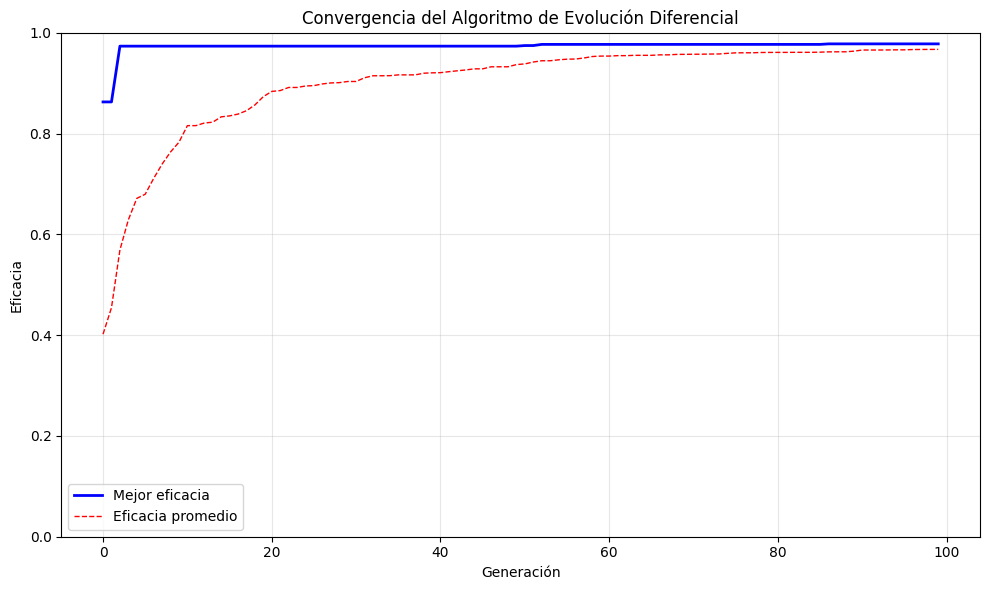

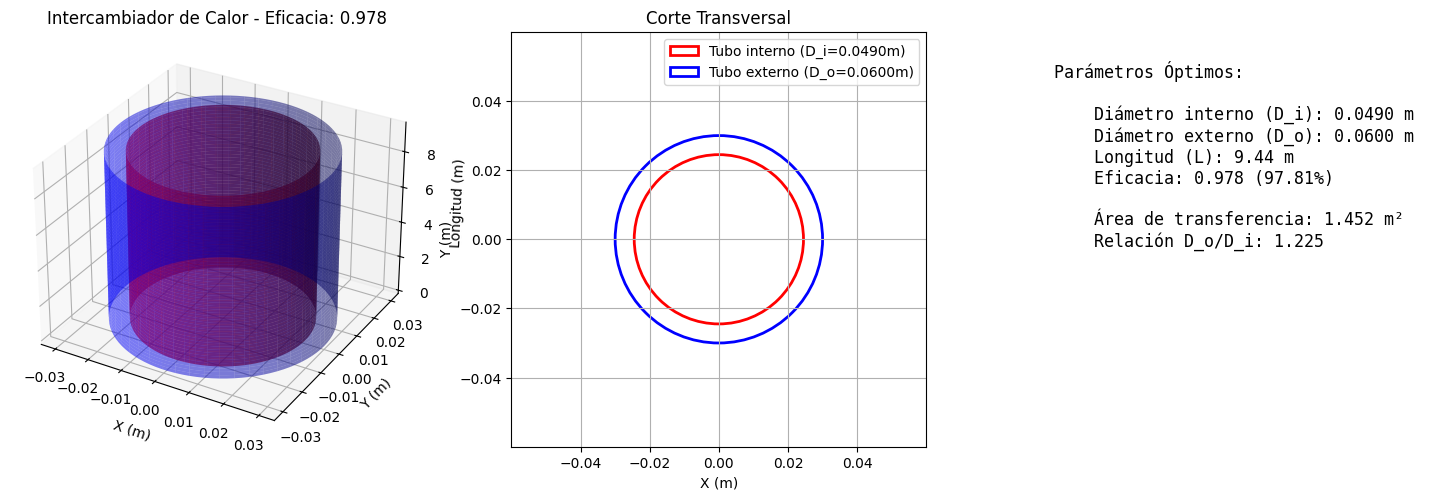

In [26]:
# Parematros del algoritmo
Tam_pob = 30
F = 0.8  # Factor de mutacion
Tasa_cruce = 0.7  # Tasa de cruce
Generaciones = 100  # Número de generaciones

# Inicializar población
poblacion = start_population(Tam_pob)
# Para guardar el progreso
mejor_por_generacion = []
promedio_por_generacion = []

for gen in range(Generaciones):
    nueva_poblacion = []
    for i in range(Tam_pob):
        MUT = mutacion_Evol_diff(poblacion, F, i)
        HIJO = cross_Ev_diff(poblacion[i], MUT, Tasa_cruce)
        HIJO = reparar_vector(HIJO)
        SELEC_N = seleccion(poblacion[i], HIJO)
        nueva_poblacion.append(SELEC_N)
    poblacion = nueva_poblacion

# Evaluar progreso
    finess = evaluar_poblacion(poblacion)
    mejor_por_generacion.append(np.max(finess))
    promedio_por_generacion.append(np.mean(finess))
    
    # Mostrar progreso cada 10 generaciones
    if gen % 10 == 0:
        print(f"Generación {gen}: Mejor eficacia = {np.max(finess):.4f}")

# Resultados finales
Fintes = evaluar_poblacion(poblacion)
mejor_indice = Fintes.index(np.max(Fintes))
mejor_individuo = poblacion[mejor_indice]
mejor_valor = Fintes[mejor_indice]

D_i, D_o, L, m_h, m_c = mejor_individuo

print("\n" + "="*50)
print("Resultados finales del algoritmo")
print(f"Mejor individuo:")
print(f"  Diámetro interno (D_i): {D_i:.4f} m")
print(f"  Diámetro externo (D_o): {D_o:.4f} m")
print(f"  Longitud (L): {L:.2f} m")
print(f"  Flujo másico caliente (m_h): {m_h:.3f} kg/s")
print(f"  Flujo másico frío (m_c): {m_c:.3f} kg/s")
print(f"Mejor valor de la función objetivo (eficacia): {mejor_valor:.4f} ({mejor_valor*100:.2f}%)")

# Gráfica de convergencia
plt.figure(figsize=(10, 6))
plt.plot(mejor_por_generacion, 'b-', linewidth=2, label='Mejor eficacia')
plt.plot(promedio_por_generacion, 'r--', linewidth=1, label='Eficacia promedio')
plt.xlabel('Generación')
plt.ylabel('Eficacia')
plt.title('Convergencia del Algoritmo de Evolución Diferencial')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Visualizar el intercambiador óptimo
visualizar_intercambiador(D_i, D_o, L, mejor_valor)
